# Анализ системы дедупликации бинарных данных

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import os

plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12
plt.style.use('seaborn-v0_8-whitegrid')

ALGO_COLORS = {'md5': '#E74C3C', 'sha256': '#2E86C1', 'sha512': '#27AE60'}
CHUNK_COLORS = {4: '#E74C3C', 32: '#E67E22', 128: '#2E86C1', 1024: '#27AE60'}

df = pd.read_csv('benchmark_results.csv')

df = df[df['file_size'] > 0].copy()
df = df[~df['file_name'].str.startswith('~$')].copy()
df.reset_index(drop=True, inplace=True)

# Базовый срез: sha256 (дубликаты одинаковы для всех алгоритмов)
sha = df[df['algo'] == 'sha256'].copy()
chunk_sizes = sorted(df['chunk_size'].unique())
origin_total = sha.groupby('file_name')['file_size'].first().sum()

print(f"Записей в CSV: {len(df)}")
print(f"Файлов: {df['file_name'].nunique()}")
print(f"Размеры сегментов: {chunk_sizes}")
print(f"Алгоритмы: {sorted(df['algo'].unique())}")
print(f"Исходный размер файлов: {origin_total:,} байт ({origin_total/1024:.1f} KB)")
df.head(18)

Записей в CSV: 288
Файлов: 24
Размеры сегментов: [np.int64(4), np.int64(32), np.int64(128), np.int64(1024)]
Алгоритмы: ['md5', 'sha256', 'sha512']
Исходный размер файлов: 716,344 байт (699.6 KB)


,file_name,file_size,chunk_size,algo,total_segments,unique_segments,duplicate_segments,storage_writes,time_hashing,time_total,storage_size
0,1688642977_75934327 (1).jpg,51994,4,md5,12999,12963,36,12963,0.350177,89.5395,51850
1,1688642977_75934327 (1).jpg,51994,4,sha256,12999,12963,36,12963,0.030295,89.5395,51850
2,1688642977_75934327 (1).jpg,51994,4,sha512,12999,12963,36,12963,0.342065,89.5395,51850
3,1688642977_75934327 (1).jpg,51994,32,md5,1625,1625,0,1625,0.042203,10.7284,51994
4,1688642977_75934327 (1).jpg,51994,32,sha256,1625,1625,0,1625,0.003387,10.7284,51994
5,1688642977_75934327 (1).jpg,51994,32,sha512,1625,1625,0,1625,0.040522,10.7284,51994
6,1688642977_75934327 (1).jpg,51994,128,md5,407,407,0,407,0.010467,2.6899,51994
7,1688642977_75934327 (1).jpg,51994,128,sha256,407,407,0,407,0.000901,2.6899,51994
8,1688642977_75934327 (1).jpg,51994,128,sha512,407,407,0,407,0.010332,2.6899,51994
9,1688642977_75934327 (1).jpg,51994,1024,md5,51,51,0,51,0.001341,0.3326,51994


## 2. Сравнение времени обработки по размерам сегментов

`time_total` — полное время прохода (чтение + хэширование + БД + хранилище).  
Левый график: общее время. Правый: среднее время на 1 сегмент — показывает, что overhead на сегмент примерно одинаковый, а разница в общем времени из-за количества сегментов.

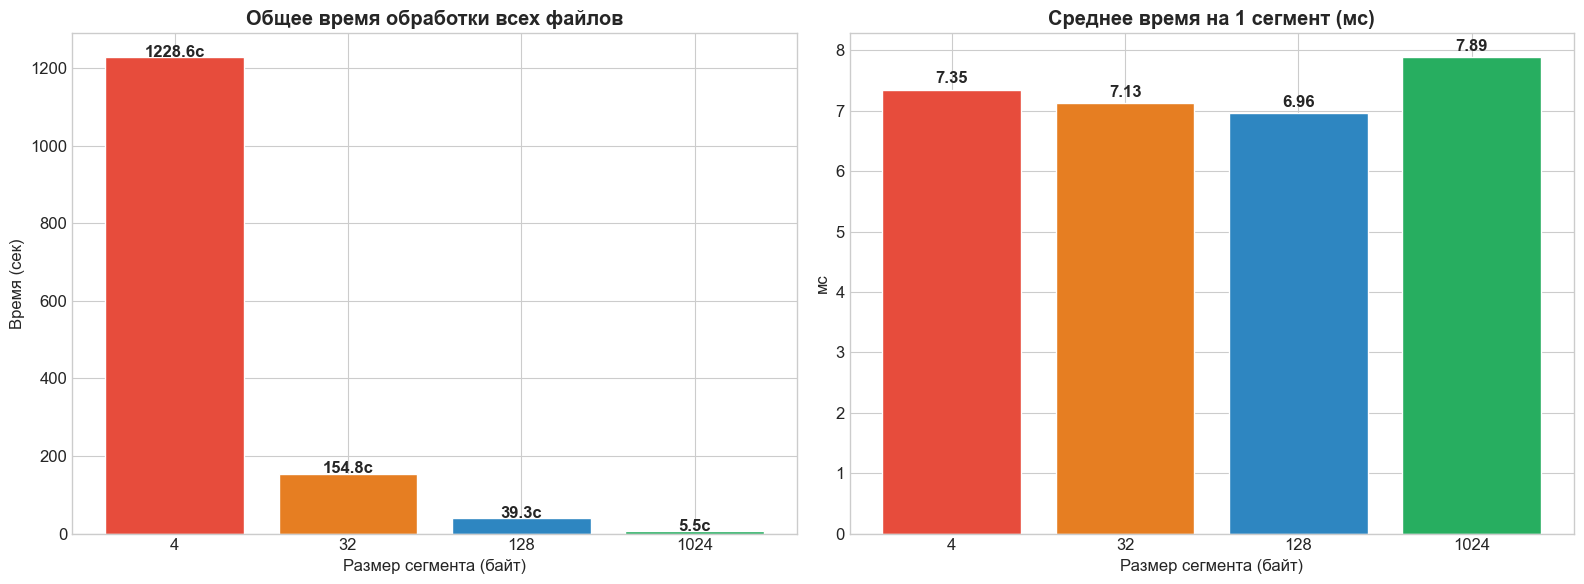

In [7]:
time_by_chunk = sha.groupby('chunk_size')['time_total'].sum().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Общее время
ax = axes[0]
bars = ax.bar(time_by_chunk['chunk_size'].astype(str), time_by_chunk['time_total'],
              color=[CHUNK_COLORS[c] for c in time_by_chunk['chunk_size']], edgecolor='white')
for bar, val in zip(bars, time_by_chunk['time_total']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{val:.1f}с', ha='center', fontweight='bold')
ax.set_title('Общее время обработки всех файлов', fontweight='bold')
ax.set_xlabel('Размер сегмента (байт)')
ax.set_ylabel('Время (сек)')

# Среднее время на 1 сегмент
sha_nz = sha[sha['total_segments'] > 0].copy()
sha_nz['ms_per_seg'] = sha_nz['time_total'] / sha_nz['total_segments'] * 1000
tps = sha_nz.groupby('chunk_size')['ms_per_seg'].mean().reset_index()

ax = axes[1]
bars = ax.bar(tps['chunk_size'].astype(str), tps['ms_per_seg'],
              color=[CHUNK_COLORS[c] for c in tps['chunk_size']], edgecolor='white')
for bar, val in zip(bars, tps['ms_per_seg']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{val:.2f}', ha='center', fontweight='bold')
ax.set_title('Среднее время на 1 сегмент (мс)', fontweight='bold')
ax.set_xlabel('Размер сегмента (байт)')
ax.set_ylabel('мс')

plt.tight_layout()
plt.show()

## 3. Уникальные и дублирующиеся сегменты

Важно различать **два уровня** подсчёта дубликатов:

| Метрика | Откуда | Что значит |
|---------|--------|------------|
| `duplicate_segments` (CSV) | Бенчмарк | Сколько раз при обработке файлов мы встретили сегмент, который **уже был в БД**. Это число совпадений за весь прогон. |
| `repits` (PostgreSQL) | Таблица `unique_segments` | Абсолютное кол-во вхождений сегмента. Если `repits = 5`, значит сегмент встречается в 5 местах (в 1 файле или в разных). |

Пример: сегмент `0xABC` встречается в 3 файлах.  
- При обработке 1-го файла: unique (записали).  
- При обработке 2-го: duplicate (+1).  
- При обработке 3-го: duplicate (+1).  
- CSV: `duplicate_segments` += 2 в сумме.  
- БД: `repits = 3`.

### 3.1 Общая картина из CSV

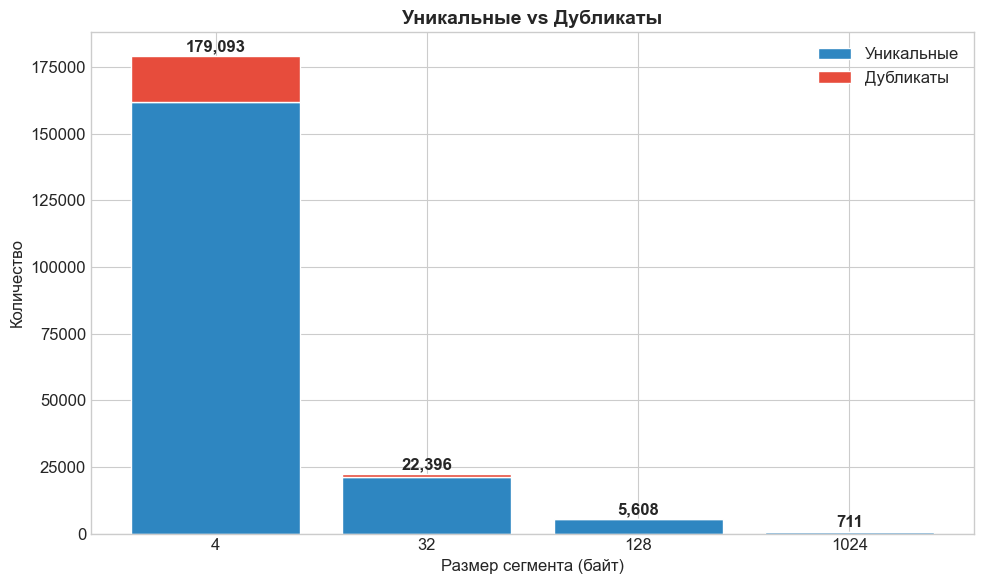

,chunk_size,total,unique,duplicate
0,4,179093,161811,17282
1,32,22396,21340,1056
2,128,5608,5433,175
3,1024,711,706,5


In [36]:
seg = sha.groupby('chunk_size').agg(
    total=('total_segments', 'sum'),
    unique=('unique_segments', 'sum'),
    duplicate=('duplicate_segments', 'sum'),
).reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bar
ax.bar(seg['chunk_size'].astype(str), seg['unique'], label='Уникальные', color='#2E86C1', edgecolor='white')
ax.bar(seg['chunk_size'].astype(str), seg['duplicate'], bottom=seg['unique'], label='Дубликаты', color='#E74C3C', edgecolor='white')

# Adding labels
for i, row in seg.iterrows():
    ax.text(i, row['total'] + (seg['total'].max() * 0.01), f"{row['total']:,}", ha='center', fontweight='bold')

ax.set_title('Уникальные vs Дубликаты', fontweight='bold', fontsize=14)
ax.set_xlabel('Размер сегмента (байт)')
ax.set_ylabel('Количество')
ax.legend()

plt.tight_layout()
plt.show()

seg_res = pd.DataFrame(seg)
seg_res

### 3.2 Глубокий анализ повторений (repits) — SQL-запросы

Для точного распределения повторений нужен прямой запрос к PostgreSQL.  


```sql
-- Распределение: сколько сегментов встречается 1 раз, 2 раза, 3 раза и т.д.
SELECT repits, COUNT(*) AS segments_count, 
       SUM(segment_size) AS total_bytes
FROM unique_segments_4_sha256
GROUP BY repits ORDER BY repits;

-- Топ-20 самых повторяющихся сегментов
SELECT segment_hash, repits, segment_size
FROM unique_segments_4_sha256
ORDER BY repits DESC LIMIT 20;

-- Точная экономия в байтах
SELECT
    SUM(segment_size)                   AS stored_bytes,
    SUM(repits * segment_size)          AS without_dedup_bytes,
    SUM((repits - 1) * segment_size)    AS saved_bytes
FROM unique_segments_4_sha256;
```

## 4. Коэффициент дедупликации (Dedup Rate)

**Dedup Rate** = `duplicate_segments / total_segments × 100%`  

Показывает какой процент сегментов НЕ нужно было записывать в хранилище.

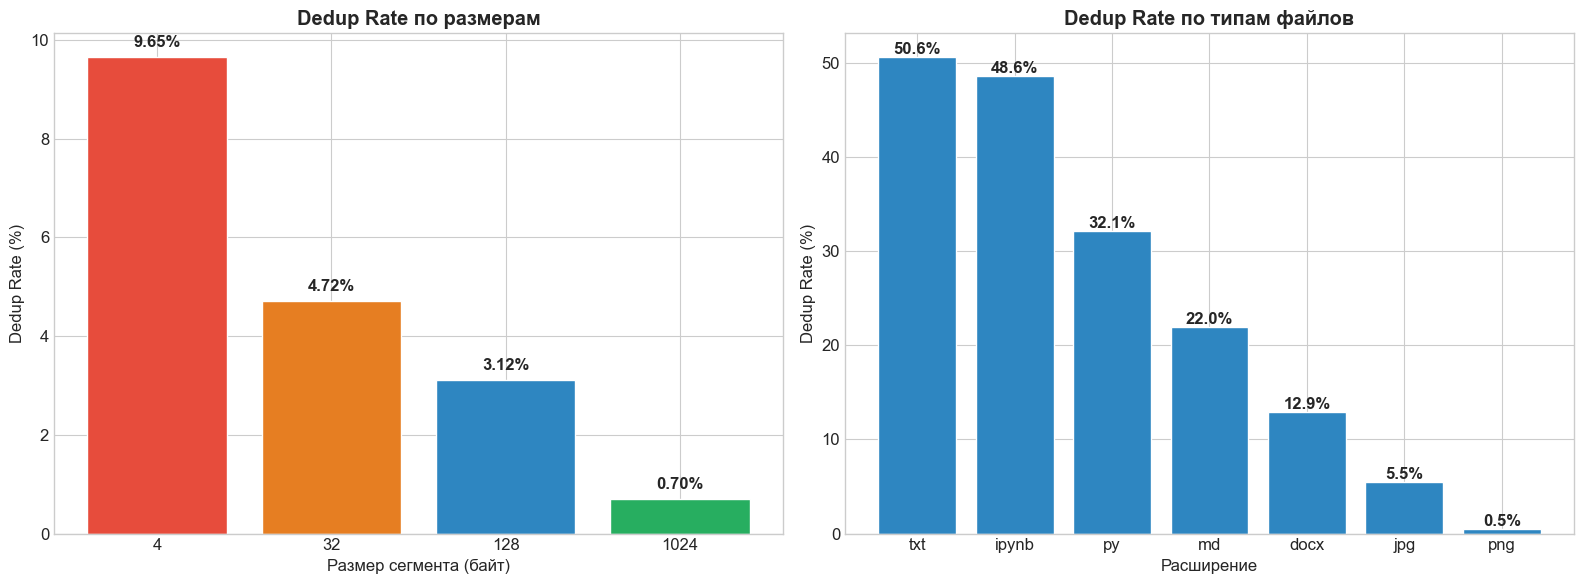

 chunk_size  total  dupes  dedup_rate
          4 179093  17282        9.65
         32  22396   1056        4.72
        128   5608    175        3.12
       1024    711      5        0.70


In [11]:
rate = sha.groupby('chunk_size').agg(
    total=('total_segments', 'sum'),
    dupes=('duplicate_segments', 'sum'),
).reset_index()
rate['dedup_rate'] = (rate['dupes'] / rate['total'] * 100).round(2)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# По chunk_size
ax = axes[0]
bars = ax.bar(rate['chunk_size'].astype(str), rate['dedup_rate'],
              color=[CHUNK_COLORS[c] for c in rate['chunk_size']], edgecolor='white')
for bar, val in zip(bars, rate['dedup_rate']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f'{val:.2f}%', ha='center', fontweight='bold', fontsize=12)
ax.set_title('Dedup Rate по размерам', fontweight='bold')
ax.set_xlabel('Размер сегмента (байт)')
ax.set_ylabel('Dedup Rate (%)')

# По типам файлов
sha_ext = sha.copy()
sha_ext['ext'] = sha_ext['file_name'].apply(lambda x: x.rsplit('.', 1)[-1].lower() if '.' in x else '?')
rate_ext = sha_ext.groupby('ext').agg(
    total=('total_segments', 'sum'), dupes=('duplicate_segments', 'sum')
).reset_index()
rate_ext['dedup_rate'] = (rate_ext['dupes'] / rate_ext['total'] * 100).round(2)
rate_ext = rate_ext.sort_values('dedup_rate', ascending=False)

ax = axes[1]
bars = ax.bar(rate_ext['ext'], rate_ext['dedup_rate'], color='#2E86C1', edgecolor='white')
for bar, val in zip(bars, rate_ext['dedup_rate']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            f'{val:.1f}%', ha='center', fontweight='bold')
ax.set_title('Dedup Rate по типам файлов', fontweight='bold')
ax.set_xlabel('Расширение')
ax.set_ylabel('Dedup Rate (%)')

plt.tight_layout()
plt.show()
print(rate.to_string(index=False))

## 5. Сравнение размеров: оригинал vs хранилище

Каждое хранилище `storage_{size}.bin` содержит **все уникальные сегменты** для данного chunk_size.  
Размер > 100% от оригинала означает overhead от хранения одних и тех же данных в разной нарезке.

In [12]:
# Размеры хранилищ с диска
storage_dir = './data_storage'
storage_sizes = {}

if os.path.exists(storage_dir):
    for cs in chunk_sizes:
        path = os.path.join(storage_dir, f'storage_{cs}.bin')
        storage_sizes[cs] = os.path.getsize(path) if os.path.exists(path) else 0
    source = "с диска"
else:
    for cs in chunk_sizes:
        storage_sizes[cs] = int(df[df['chunk_size'] == cs]['storage_size'].max())
    source = "из CSV (максимальное значение storage_size)"

print(f"Источник: {source}")
print(f"Оригинал (origin_data): {origin_total:,} байт ({origin_total/1024:.1f} KB)\n")
for cs, sz in storage_sizes.items():
    pct = sz / origin_total * 100
    print(f"  storage_{cs}.bin: {sz:>10,} байт  ({pct:>6.1f}% от оригинала)")

total_all = sum(storage_sizes.values())
print(f"\n  ИТОГО хранилища: {total_all:,} байт ({total_all / origin_total:.2f}x от оригинала)")

Источник: с диска
Оригинал (origin_data): 716,344 байт (699.6 KB)

  storage_4.bin:    647,329 байт  (  90.4% от оригинала)
  storage_32.bin:    682,714 байт  (  95.3% от оригинала)
  storage_128.bin:    694,106 байт  (  96.9% от оригинала)
  storage_1024.bin:    711,386 байт  (  99.3% от оригинала)

  ИТОГО хранилища: 2,735,535 байт (3.82x от оригинала)


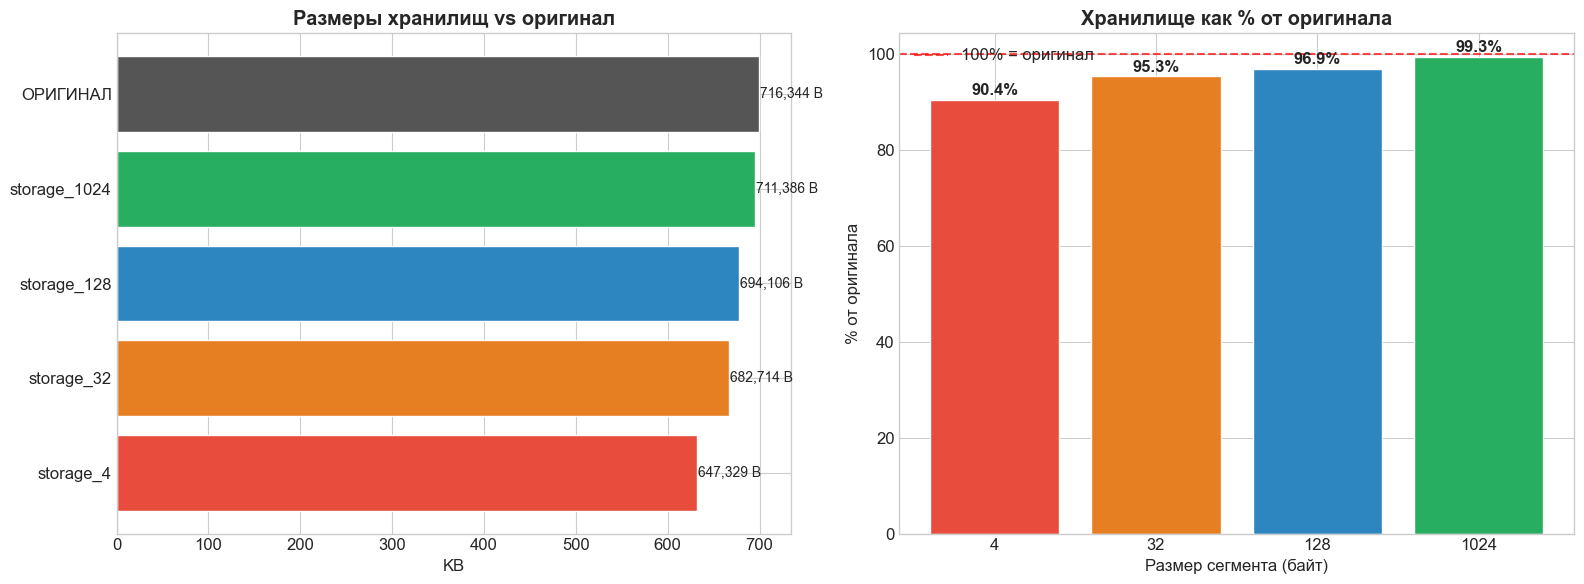

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Горизонтальный bar
ax = axes[0]
labels = [f'storage_{cs}' for cs in chunk_sizes] + ['ОРИГИНАЛ']
sizes = [storage_sizes[cs] for cs in chunk_sizes] + [origin_total]
colors_list = [CHUNK_COLORS[cs] for cs in chunk_sizes] + ['#555555']

bars = ax.barh(labels, [s / 1024 for s in sizes], color=colors_list, edgecolor='white')
for bar, val in zip(bars, sizes):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
            f'{val:,} B', va='center', fontsize=10)
ax.set_title('Размеры хранилищ vs оригинал', fontweight='bold')
ax.set_xlabel('KB')

# Процент от оригинала
ax = axes[1]
eff = [storage_sizes[cs] / origin_total * 100 for cs in chunk_sizes]
bars = ax.bar([str(cs) for cs in chunk_sizes], eff,
              color=[CHUNK_COLORS[cs] for cs in chunk_sizes], edgecolor='white')
ax.axhline(y=100, color='red', linestyle='--', alpha=0.7, label='100% = оригинал')
for bar, val in zip(bars, eff):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{val:.1f}%', ha='center', fontweight='bold')
ax.set_title('Хранилище как % от оригинала', fontweight='bold')
ax.set_xlabel('Размер сегмента (байт)')
ax.set_ylabel('% от оригинала')
ax.legend()

plt.tight_layout()
plt.show()

## 6. Дополнительные метрики

### 6.1 Пропускная способность (Throughput)
Сколько KB/s система обрабатывает при разных chunk_size.

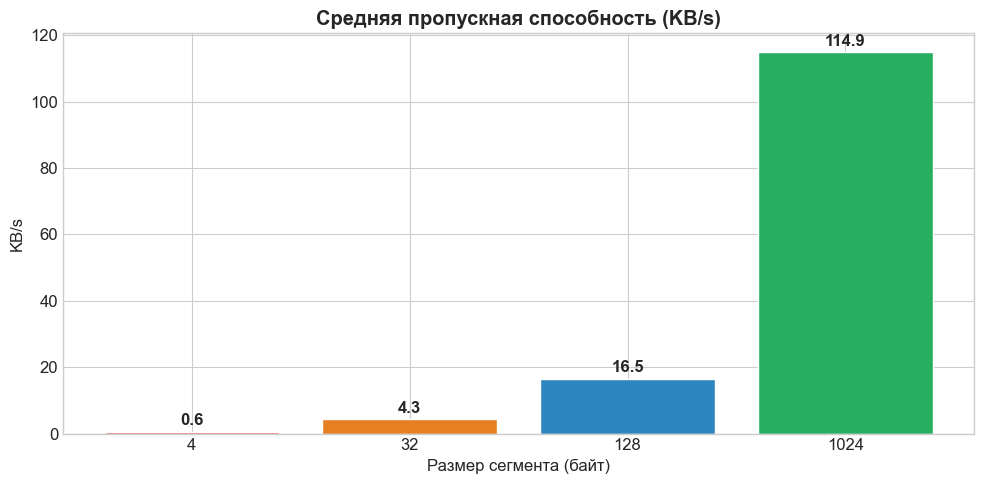

Крупные сегменты — значительно быстрее (меньше обращений к БД на тот же объём данных).


In [14]:
sha_tp = sha[sha['time_total'] > 0].copy()
sha_tp['throughput_kbps'] = sha_tp['file_size'] / 1024 / sha_tp['time_total']
tp = sha_tp.groupby('chunk_size')['throughput_kbps'].mean().reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(tp['chunk_size'].astype(str), tp['throughput_kbps'],
              color=[CHUNK_COLORS[c] for c in tp['chunk_size']], edgecolor='white')
for bar, val in zip(bars, tp['throughput_kbps']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{val:.1f}', ha='center', fontweight='bold')
ax.set_title('Средняя пропускная способность (KB/s)', fontweight='bold')
ax.set_xlabel('Размер сегмента (байт)')
ax.set_ylabel('KB/s')
plt.tight_layout()
plt.show()

print("Крупные сегменты — значительно быстрее (меньше обращений к БД на тот же объём данных).")

### 6.2 Overhead метаданных

Оценка: сколько места занимают записи в PostgreSQL vs сами данные.  
- `unique_segments`: ~100 байт/строка (hash 64B + offset 8B + size 4B + repits 4B + index)
- `file_chunks`: ~80 байт/строка (file_id 4B + chunk_index 4B + hash 64B + index)

При мелком chunk_size метаданные могут **превысить** размер самих данных.

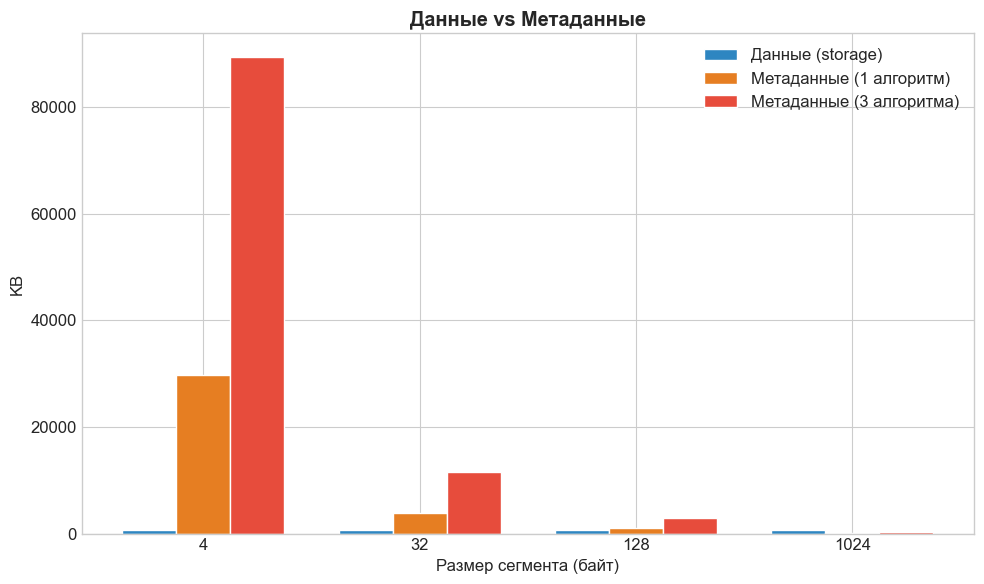

 chunk_size  unique_seg  total_seg  storage  meta_1algo  overhead_1_%  meta_3algo  overhead_3_%
          4      161811     179093   647329    30508540        4713.0    91525620       14139.0
         32       21340      22396   682714     3925680         575.0    11777040        1725.0
        128        5433       5608   694106      991940         142.9     2975820         428.7
       1024         706        711   711386      127480          17.9      382440          53.8

При chunk_size=4 метаданные в разы БОЛЬШЕ самих данных.


In [15]:
BYTES_PER_UNIQUE = 100
BYTES_PER_CHUNK = 80

meta = sha.groupby('chunk_size').agg(
    total_seg=('total_segments', 'sum'),
    unique_seg=('unique_segments', 'sum'),
).reset_index()

# Метаданные для ОДНОГО алгоритма
meta['meta_1algo'] = meta['unique_seg'] * BYTES_PER_UNIQUE + meta['total_seg'] * BYTES_PER_CHUNK
# Для ТРЁХ алгоритмов (в реальной БД — 3 пары таблиц на chunk_size)
meta['meta_3algo'] = meta['meta_1algo'] * 3
meta['storage'] = [storage_sizes[cs] for cs in meta['chunk_size']]
meta['overhead_1_%'] = (meta['meta_1algo'] / meta['storage'] * 100).round(1)
meta['overhead_3_%'] = (meta['meta_3algo'] / meta['storage'] * 100).round(1)

fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(meta))
w = 0.25
ax.bar([i - w for i in x], meta['storage'] / 1024, w,
       label='Данные (storage)', color='#2E86C1', edgecolor='white')
ax.bar([i for i in x], meta['meta_1algo'] / 1024, w,
       label='Метаданные (1 алгоритм)', color='#E67E22', edgecolor='white')
ax.bar([i + w for i in x], meta['meta_3algo'] / 1024, w,
       label='Метаданные (3 алгоритма)', color='#E74C3C', edgecolor='white')
ax.set_xticks(list(x))
ax.set_xticklabels(meta['chunk_size'].astype(str))
ax.set_title('Данные vs Метаданные', fontweight='bold')
ax.set_xlabel('Размер сегмента (байт)')
ax.set_ylabel('KB')
ax.legend()
plt.tight_layout()
plt.show()

print(meta[['chunk_size', 'unique_seg', 'total_seg', 'storage',
            'meta_1algo', 'overhead_1_%', 'meta_3algo', 'overhead_3_%']].to_string(index=False))
print("\nПри chunk_size=4 метаданные в разы БОЛЬШЕ самих данных.")

### 6.3 Консистентность алгоритмов

Проверка: все ли алгоритмы находят одинаковое количество уникальных сегментов?  
Если расхождение — возможна **хэш-коллизия** (два разных блока дали одинаковый хэш).

In [17]:
cons = df.pivot_table(index=['file_name', 'chunk_size'], columns='algo',
                      values='unique_segments', aggfunc='first')
cons['consistent'] = cons.apply(lambda r: r.nunique() == 1, axis=1)
bad = cons[~cons['consistent']]

if len(bad) == 0:
    print(" Все алгоритмы дают одинаковое количество уникальных сегментов.")
    print(" Коллизий не обнаружено ни для одной пары (файл × chunk_size).")
else:
    print(f"{len(bad)} расхождений — возможны коллизии:")
    print(bad)

 Все алгоритмы дают одинаковое количество уникальных сегментов.
 Коллизий не обнаружено ни для одной пары (файл × chunk_size).


### 6.4 Экономия хранилища (Storage Savings)

Сравнение: сколько бы заняли данные **без дедупликации** (сумма file_size) vs реальный размер хранилища.

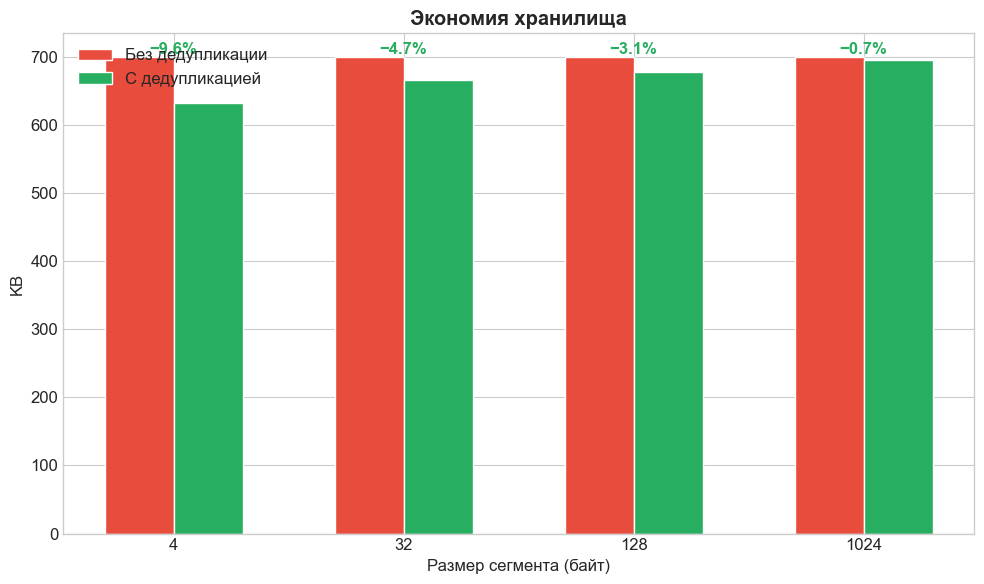

 chunk_size  without_dedup  with_dedup   saved  saving_%
          4       716344.0    647329.0 69015.0  9.634338
         32       716344.0    682714.0 33630.0  4.694672
        128       716344.0    694106.0 22238.0  3.104374
       1024       716344.0    711386.0  4958.0  0.692126


In [18]:
savings = pd.DataFrame({'chunk_size': chunk_sizes})
for i, cs in enumerate(chunk_sizes):
    without = sha[sha['chunk_size'] == cs]['file_size'].sum()
    actual = storage_sizes[cs]
    savings.at[i, 'without_dedup'] = without
    savings.at[i, 'with_dedup'] = actual
    savings.at[i, 'saved'] = without - actual
    savings.at[i, 'saving_%'] = ((without - actual) / without * 100) if without > 0 else 0

fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(savings))
w = 0.3
ax.bar([i - w/2 for i in x], savings['without_dedup'] / 1024, w,
       label='Без дедупликации', color='#E74C3C', edgecolor='white')
ax.bar([i + w/2 for i in x], savings['with_dedup'] / 1024, w,
       label='С дедупликацией', color='#27AE60', edgecolor='white')
ax.set_xticks(list(x))
ax.set_xticklabels(savings['chunk_size'].astype(int).astype(str))
for i, row in savings.iterrows():
    ax.text(i, max(row['without_dedup'], row['with_dedup']) / 1024 + 5,
            f"−{row['saving_%']:.1f}%", ha='center', fontweight='bold', color='#27AE60')
ax.set_title('Экономия хранилища', fontweight='bold')
ax.set_xlabel('Размер сегмента (байт)')
ax.set_ylabel('KB')
ax.legend()
plt.tight_layout()
plt.show()

print(savings.to_string(index=False))

### 6.5 Сводная таблица

In [21]:
summary = sha.groupby('chunk_size').agg(
    files=('file_name', 'nunique'),
    total_segments=('total_segments', 'sum'),
    unique_segments=('unique_segments', 'sum'),
    duplicate_segments=('duplicate_segments', 'sum'),
    total_time_sec=('time_total', 'sum'),
).reset_index()

summary['dedup_rate_%'] = (summary['duplicate_segments'] / summary['total_segments'] * 100).round(2)
summary['avg_ms_per_seg'] = (summary['total_time_sec'] / summary['total_segments'] * 1000).round(2)
summary['storage_KB'] = [round(storage_sizes[cs] / 1024, 1) for cs in summary['chunk_size']]
summary['throughput_KB/s'] = (
    sha[sha['time_total'] > 0].groupby('chunk_size')
    .apply(lambda g: g['file_size'].sum() / 1024 / g['time_total'].sum())
    .values
).round(1)

summary = pd.DataFrame(summary)
summary

,chunk_size,files,total_segments,unique_segments,duplicate_segments,total_time_sec,dedup_rate_%,avg_ms_per_seg,storage_KB,throughput_KB/s
0,4,24,179093,161811,17282,1228.6485,9.65,6.86,632.2,0.6
1,32,24,22396,21340,1056,154.7789,4.72,6.91,666.7,4.5
2,128,24,5608,5433,175,39.3025,3.12,7.01,677.8,17.8
3,1024,24,711,706,5,5.4789,0.70,7.71,694.7,127.7
